In [15]:
import torch # Is this import needed
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision # Is this import needed
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

# What does this??
%matplotlib inline

# Transform module

Converts the data to tensors and pre-processes the data to normalize it with the standard deviation of 1.

In [16]:
transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

Creates the train and test data of the MNIST dataset

In [17]:
train_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    transform=transform,
    download=True)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

Creates the dataloaders of the train and test datasets. The `DataLoader` is a PyTorch module to combine the data and it's labels in a package, so that it is easily accesable. 
`batch_size` = creating a batch of `n` numbers for one iteration

In [18]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

## Visulize data

In [19]:
train_dataloader.dataset.data.shape

torch.Size([60000, 28, 28])

### Visualize a batch of data

<ipython-input-20-87fd2e2df469>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, index+1, xticks=[], yticks=[])


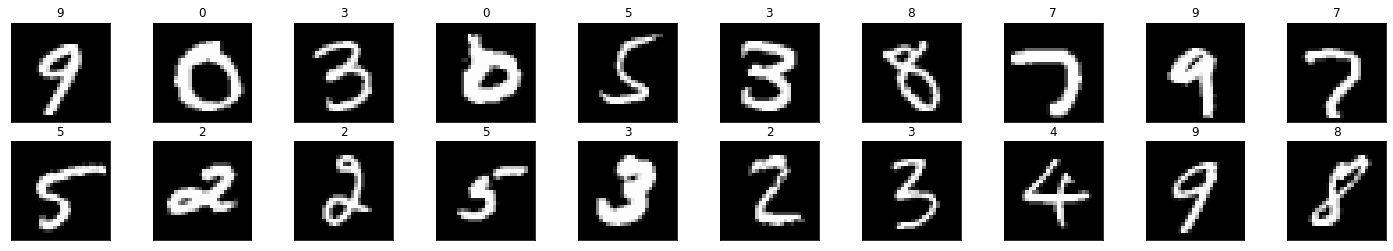

In [20]:
# obtain one batch of training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for index in np.arange(20):
    ax = fig.add_subplot(2, 20/2, index+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[index]), cmap='gray')

    ax.set_title(str(labels[index].item()))

### Visulize an image in more detail

width: 28, height: 28
thresh: 0.4


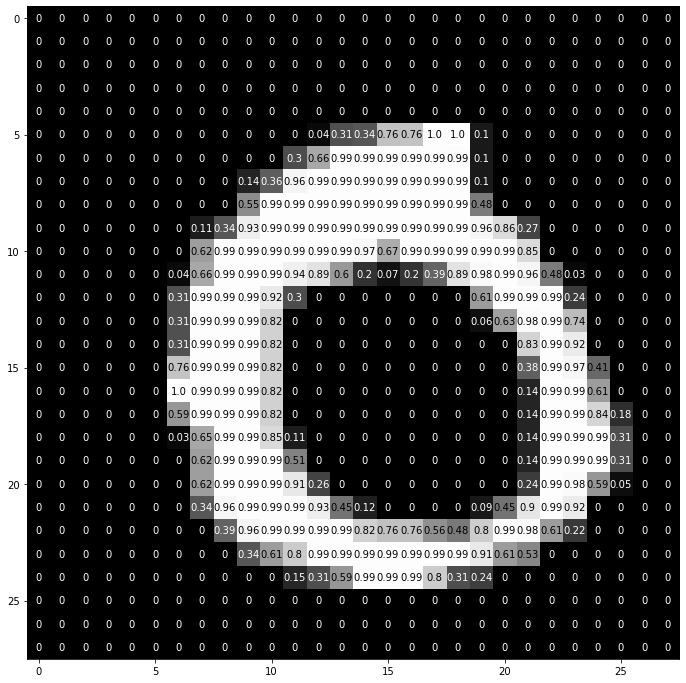

In [21]:
# Obtain an random image
image = np.squeeze(images[1])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')
width, height = image.shape
print(f"width: {width}, height: {height}")

thresh = image.max()/2.5
print(f"thresh: {thresh}")

for x in range(width):
    for y in range(height):
        # Set value of each pixel in the image
        val = round(image[x][y], 2) if image[x][y] != 0 else 0
        ax.annotate(
            str(val), 
            xy=(y, x),
            horizontalalignment='center',
            verticalalignment='center',
            color='white' if image[x][y] < thresh else 'black'
        )


# MLP - NN Model
The model will have a input size of 784 which is the product of the height(28) and width(28) of the image. The output size of the model will be 10 because we have digits of 0-9 therefor there is a total of 10 possibilities.

In [22]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Flatten image input
        x = x.view(-1, 28 * 28)
        # Add hidden layer
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add hidden layer
        x = F.relu(self.fc2(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add output layer
        x = self.fc3(x)

        return x


In [23]:
model = MLP()
model

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Loss function and Optimizer

In [24]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Train the NN

Steps of training the model:

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss with the loss function
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perdorm a single optimization step (parameter update)
6. Update average training loss

In [35]:
n_epochs = 15

valid_loss_min = np.inf

model.train()

for epoch in range(n_epochs):
    # Monitor the training loss
    train_loss = 0.0

    # Training the model #
    for data, traget in train_dataloader:
        # Sets the gradient to zero
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, traget)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    
    train_loss = train_loss / len(train_dataloader.dataset)

    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}')

    # validate the model #
    model.eval()  # prep model for evaluation
    for data,label in test_dataloader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_function(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(test_dataloader.sampler)
    valid_loss = valid_loss / len(test_dataloader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.150611
Epoch: 1 	Training Loss: 0.000015 	Validation Loss: 0.000040
Validation loss decreased (inf --> 0.000040).  Saving model ...
Epoch: 2 	Training Loss: 0.124791
Epoch: 2 	Training Loss: 0.000012 	Validation Loss: 0.000736
Epoch: 3 	Training Loss: 0.118394
Epoch: 3 	Training Loss: 0.000012 	Validation Loss: 0.000029
Validation loss decreased (0.000040 --> 0.000029).  Saving model ...
Epoch: 4 	Training Loss: 0.112568
Epoch: 4 	Training Loss: 0.000011 	Validation Loss: 0.000259
Epoch: 5 	Training Loss: 0.107216
Epoch: 5 	Training Loss: 0.000011 	Validation Loss: 0.000020
Validation loss decreased (0.000029 --> 0.000020).  Saving model ...
Epoch: 6 	Training Loss: 0.102508
Epoch: 6 	Training Loss: 0.000010 	Validation Loss: 0.000174
Epoch: 7 	Training Loss: 0.097830
Epoch: 7 	Training Loss: 0.000010 	Validation Loss: 0.000267
Epoch: 8 	Training Loss: 0.093846
Epoch: 8 	Training Loss: 0.000009 	Validation Loss: 0.000076
Epoch: 9 	Training Loss: 0.089954
Epoc

## Test model

In [37]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = loss_function(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1# calculate and print avg test loss
    test_loss = test_loss/len(test_dataloader.sampler)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)')
            print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.000216

Test Accuracy of     0: 100% ( 9/ 9)
Test Accuracy of     1: 100% ( 9/ 9)
Test Accuracy of     2: 100% ( 4/ 4)
Test Accuracy of     3: 100% ( 7/ 7)
Test Accuracy of     4: 100% ( 6/ 6)
Test Accuracy of     5: 66% ( 2/ 3)
Test Accuracy of     6: 100% ( 7/ 7)
Test Accuracy of     7: 100% ( 7/ 7)
Test Accuracy of     8: 100% ( 7/ 7)
Test Accuracy of     9: 100% ( 5/ 5)
Test Loss: 0.000244

Test Accuracy of     0: 100% (20/20)
Test Accuracy of     1: 100% (14/14)
Test Accuracy of     2: 100% (13/13)
Test Accuracy of     3: 100% (11/11)
Test Accuracy of     4: 100% (11/11)
Test Accuracy of     5: 90% ( 9/10)
Test Accuracy of     6: 100% (10/10)
Test Accuracy of     7: 100% (14/14)
Test Accuracy of     8: 100% (11/11)
Test Accuracy of     9: 100% (14/14)
Test Loss: 0.001008

Test Accuracy of     0: 96% (25/26)
Test Accuracy of     1: 100% (19/19)
Test Accuracy of     2: 100% (21/21)
Test Accuracy of     3: 100% (17/17)
Test Accuracy of     4: 100% (18/18)
Test Accuracy o

## Visualize results

<ipython-input-36-caf36fcc2487>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


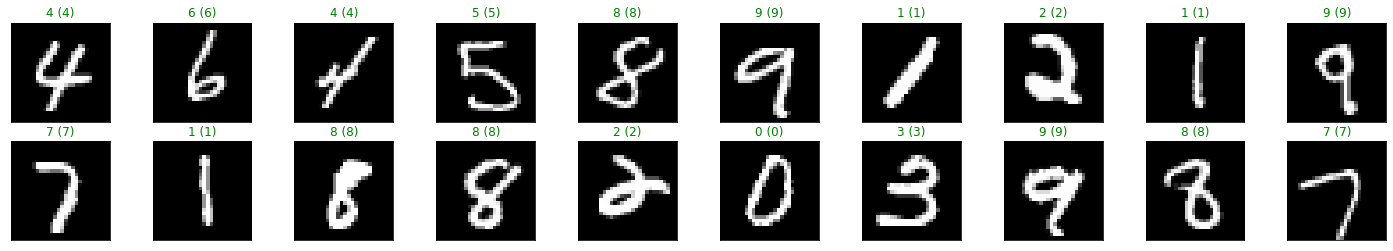

In [36]:
# obtain one batch of test images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(f"{str(preds[idx].item())} ({str(labels[idx].item())})",
                 color=("green" if preds[idx]==labels[idx] else "red"))